# ECON 148B Project Task 1

Task 1: predicting mortgage defaults (75 points)
There are two data sets for this task (Econ148_project_Task1_train.csv and Econ148_project_Task1_future.csv). They can be downloaded from this link (you might need to log into your Brandeis account to access this Box file). The goal is to predict the "target" column. The "id" column is just a serial number. The rest are 54 features. You need to make important decisions on how to handle these features, including distinguishing continuous and categorical variables. 

Submit: Each team submits a team project report (a pdf file), codes (a Jupyter notebook), and the prediction results (a csv file) for the observations in "Econ148_project_Task1_future.csv". 

If you use methods that are not covered in the course, you need to explain the methodology clearly in your pdf report. Failing to deliver adequate explanations will lead to deduction of points.

Grading: 40% report + 60% performance (F1 score)

In the column "target", 1 is treated as positive and 0 is treated as negative when computing the F1 score. 
If you do not have valid predictions in the csv file or if your Python code (in the submitted Jupyter notebook) does not reproduce the submitted csv file, then you will get zero for performance.
When you submit the csv file, you only need to include two columns: prediction and "id". This way the csv file will not be too large.

## Loading Packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, SelectKBest
from imblearn.over_sampling import SMOTE


## Reading CSV Files

In [7]:
df = pd.read_csv('Econ148_project_Task1_train.csv')
df_future = pd.read_csv('Econ148_project_Task1_future.csv')

# Exploratory Data Analysis (EDA)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372192 entries, 0 to 372191
Data columns (total 56 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Feature_1   372192 non-null  int64  
 1   Feature_2   235204 non-null  float64
 2   Feature_3   372192 non-null  int64  
 3   Feature_4   372191 non-null  float64
 4   Feature_5   219881 non-null  float64
 5   Feature_6   39674 non-null   float64
 6   Feature_7   167106 non-null  float64
 7   Feature_8   121838 non-null  float64
 8   Feature_9   372192 non-null  float64
 9   Feature_10  372191 non-null  float64
 10  Feature_11  372191 non-null  float64
 11  Feature_12  372192 non-null  float64
 12  Feature_13  372192 non-null  float64
 13  Feature_14  46696 non-null   float64
 14  Feature_15  372192 non-null  object 
 15  Feature_16  372192 non-null  object 
 16  Feature_17  264581 non-null  float64
 17  Feature_18  372192 non-null  object 
 18  Feature_19  771 non-null     float64
 19  Fe

In [10]:
df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54,target,id
0,90,176258.480,4140,2295.6,8497.601,NaN,84390.750,12635.601,60000.0,11437.2,...,NaN,NaN,NaN,50000.0,False,OWNED,NaN,NaN,0,543320
1,19,16329.000,1580,0.0,2721.600,NaN,7948.572,NaN,20000.0,0.0,...,NaN,NaN,5912.4,20000.0,False,NaN,NaN,NaN,0,5256
2,45,21987.201,1320,0.0,1047.000,NaN,893.000,930.200,19998.0,0.0,...,NaN,NaN,NaN,30000.0,False,NaN,NaN,NaN,0,1498866
3,90,NaN,5140,0.0,NaN,NaN,NaN,NaN,130000.0,0.0,...,NaN,16671.8,NaN,138000.0,False,NaN,NaN,NaN,0,111141
4,60,79041.600,3642,3592.8,3592.800,NaN,53748.676,3592.800,84000.0,42621.1,...,NaN,NaN,NaN,90000.0,False,NaN,NaN,NaN,0,661319


In [11]:
df['target'].value_counts()

target
0    359452
1     12740
Name: count, dtype: int64

In [12]:
df.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_39,Feature_40,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_53,target,id
count,372192.000000,2.352040e+05,372192.000000,372191.000000,219881.000000,39674.000000,1.671060e+05,121838.000000,372192.000000,3.721910e+05,...,3.721910e+05,85941.000000,35184.000000,28093.000000,17583.000000,139623.000000,372192.000000,8884.000000,372192.000000,3.721920e+05
mean,40.724317,5.611037e+04,4062.630263,1442.012154,5397.389715,44542.460203,4.616133e+04,6423.522792,49892.093623,1.975288e+04,...,9.230399e+04,10451.028081,9292.589682,10045.387193,17708.774002,13180.535215,57688.514065,20.119564,0.034230,7.621005e+05
std,23.803758,7.191524e+04,3074.324731,2808.595597,6485.735597,44769.328758,6.360045e+04,9357.605504,44294.923948,5.104712e+04,...,1.542773e+05,16318.599975,5579.906399,5746.892342,6931.552874,18108.734109,33345.122254,87.113882,0.181819,4.412648e+05
min,0.000000,0.000000e+00,118.000000,0.000000,0.000000,0.000000,-2.162718e+05,0.000000,2000.000000,0.000000e+00,...,0.000000e+00,0.458000,0.000000,5.600000,31.800001,0.000000,0.000000,0.000000,0.000000,2.000000e+00
25%,23.000000,7.401600e+03,1960.000000,0.000000,2530.800000,15596.500000,8.700000e+03,2595.800000,19998.000000,0.000000e+00,...,0.000000e+00,3302.000000,6612.675000,7192.200000,13667.100000,3114.000000,36000.000000,0.000000,0.000000,3.796472e+05
50%,40.000000,2.973411e+04,3156.000000,0.000000,4058.000000,28419.400000,2.279650e+04,4407.100000,35188.000000,0.000000e+00,...,3.588760e+04,6219.200000,7305.900000,7553.000000,15780.000000,8400.000000,50000.000000,0.000000,0.000000,7.607145e+05
75%,55.000000,7.652791e+04,5265.000000,2047.500000,6545.800300,55707.850500,5.571635e+04,7544.200000,63978.000000,1.362750e+04,...,1.186690e+05,11719.200000,13001.850500,13464.400000,21894.100000,16985.018500,70000.000000,2.600000,0.000000,1.144412e+06
max,91.000000,1.128893e+06,74786.000000,56020.000000,318163.000000,496148.800000,1.036999e+06,378638.220000,600000.000000,1.022051e+06,...,2.307942e+07,794899.200000,145257.400000,205848.610000,98373.400000,459898.250000,200000.000000,967.800000,1.000000,1.526659e+06


### Checking for percentage of missing values

In [14]:
(df.isna().sum()/df['Feature_1'].count()) * 100

Feature_1      0.000000
Feature_2     36.805735
Feature_3      0.000000
Feature_4      0.000269
Feature_5     40.922696
Feature_6     89.340448
Feature_7     55.102205
Feature_8     67.264745
Feature_9      0.000000
Feature_10     0.000269
Feature_11     0.000269
Feature_12     0.000000
Feature_13     0.000000
Feature_14    87.453787
Feature_15     0.000000
Feature_16     0.000000
Feature_17    28.912765
Feature_18     0.000000
Feature_19    99.792849
Feature_20    99.795804
Feature_21     0.000000
Feature_22     0.000000
Feature_23    50.383136
Feature_24     0.000000
Feature_25     0.000000
Feature_26    33.405608
Feature_27    20.023268
Feature_28    94.996937
Feature_29    20.023268
Feature_30    40.922696
Feature_31    67.658628
Feature_32    50.265186
Feature_33    73.961826
Feature_34     0.000000
Feature_35    14.562108
Feature_36    29.125828
Feature_37    55.055455
Feature_38     0.000269
Feature_39     0.000269
Feature_40    76.909498
Feature_41     1.739693
Feature_42     1

### Dropping columns that have a large percentage of missing values (>85% missing)

In [16]:
df_dropped = df.dropna(axis = 1, thresh = len(df)* 0.15)

In [17]:
df_dropped = df_dropped.drop(axis = 1, columns = ['id','target'])

In [18]:
y = df['target']

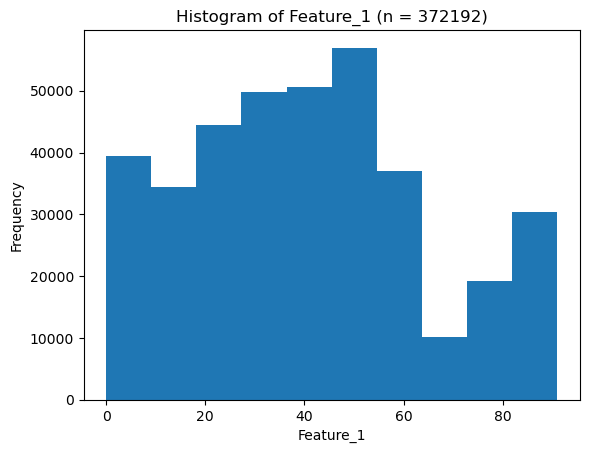

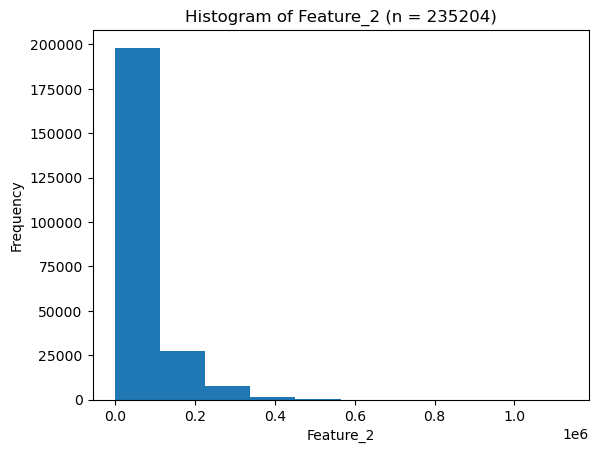

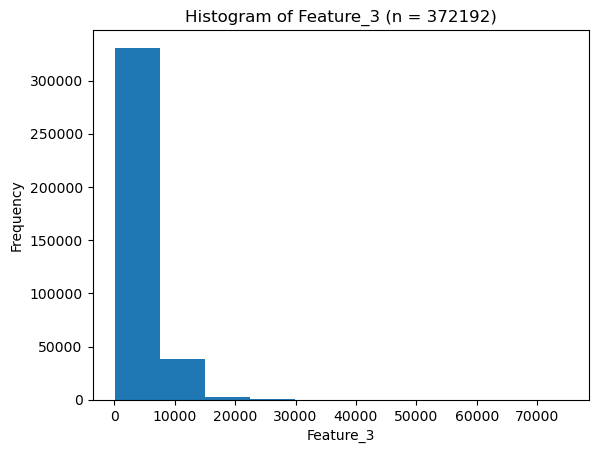

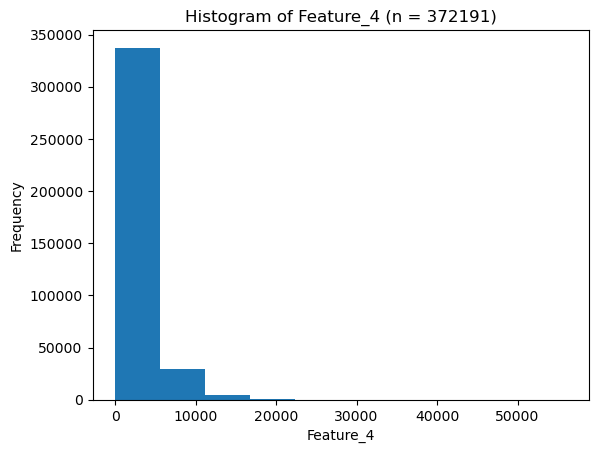

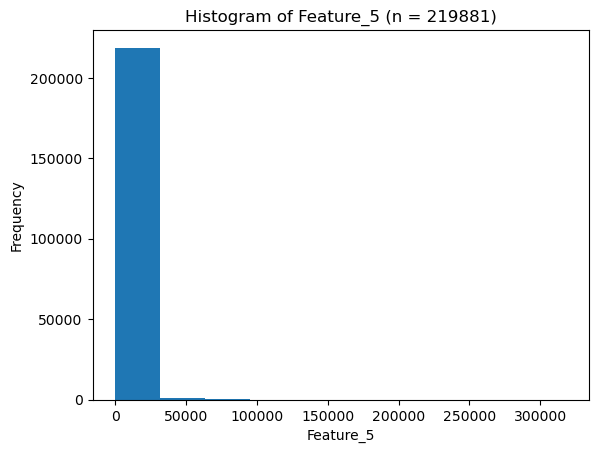

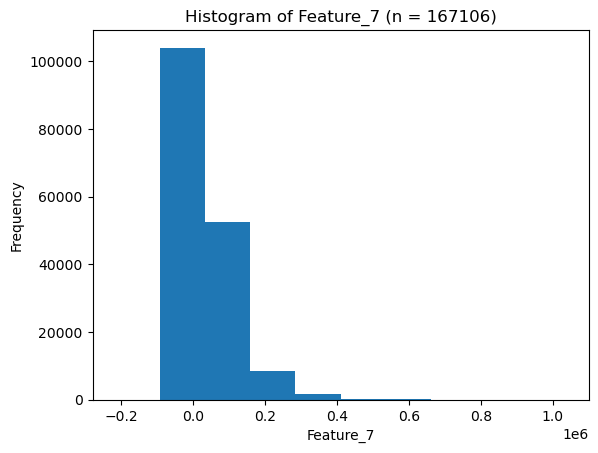

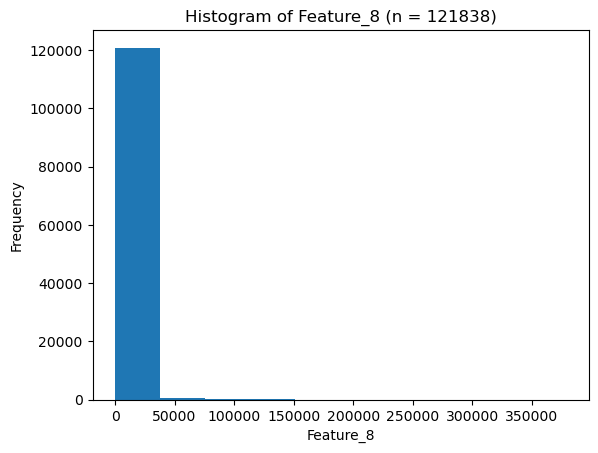

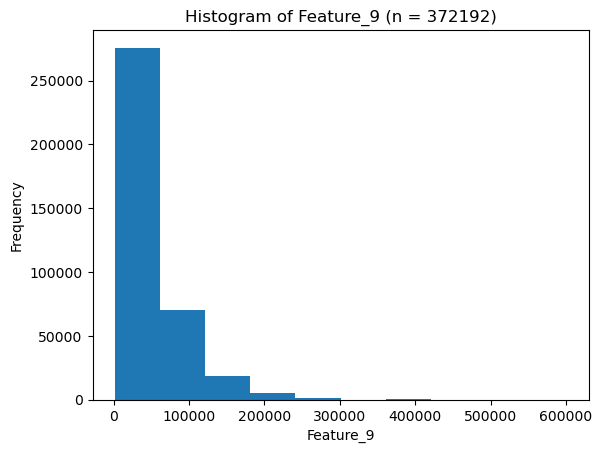

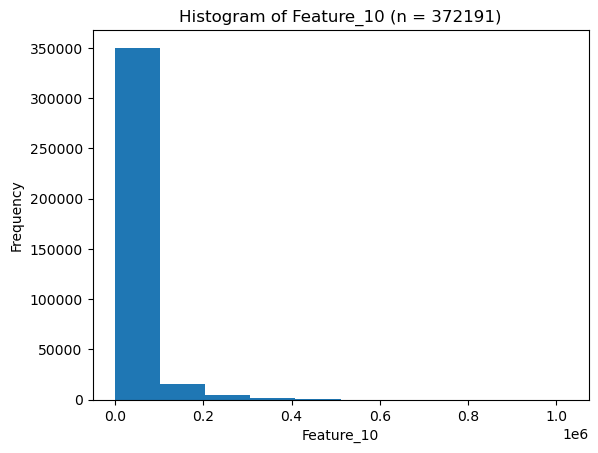

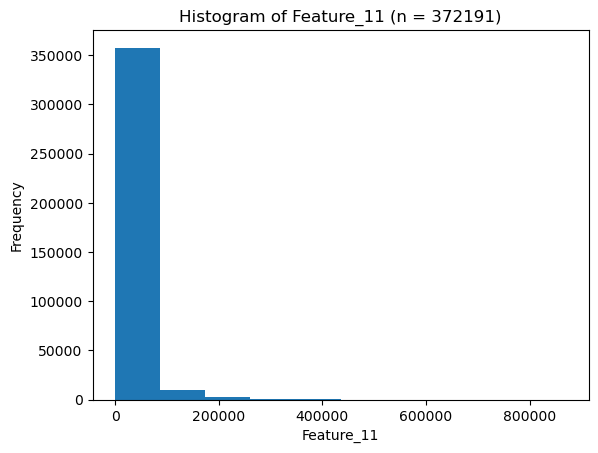

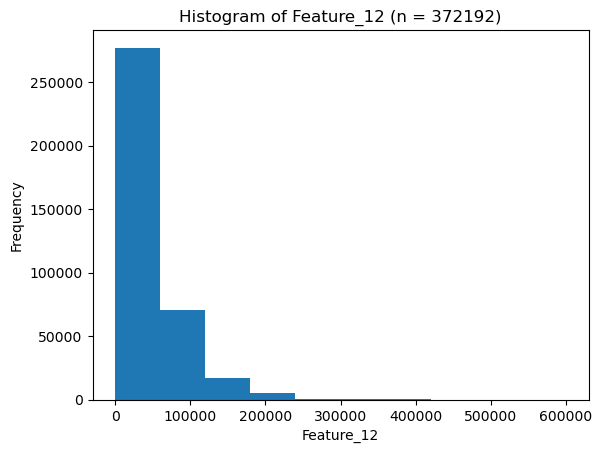

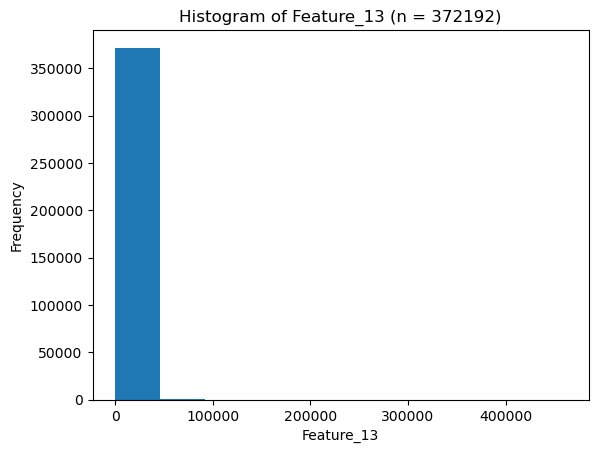

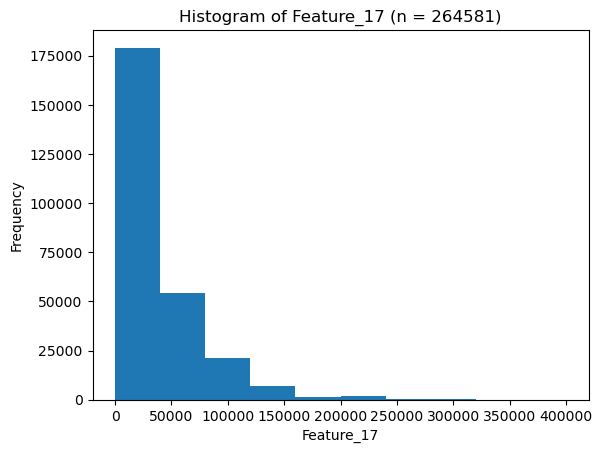

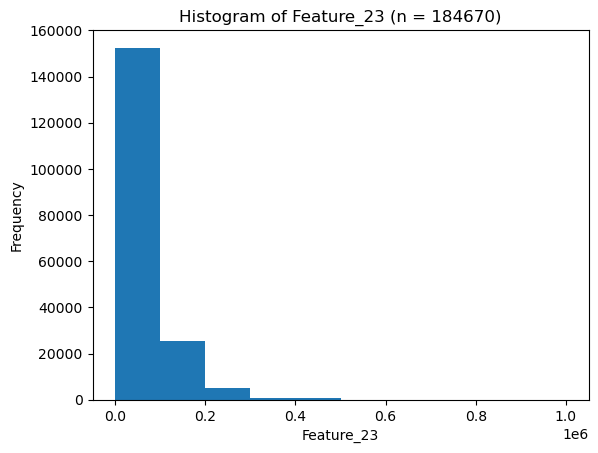

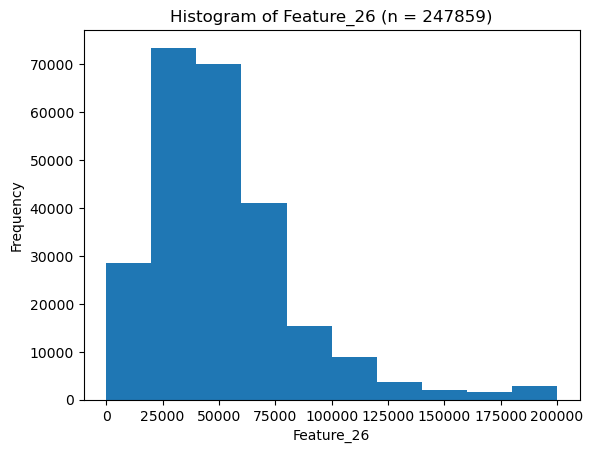

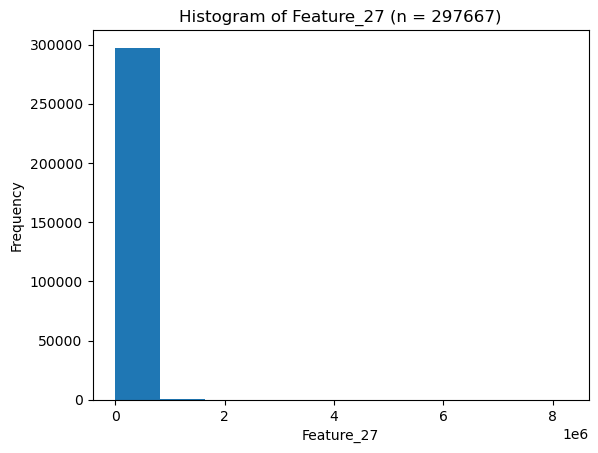

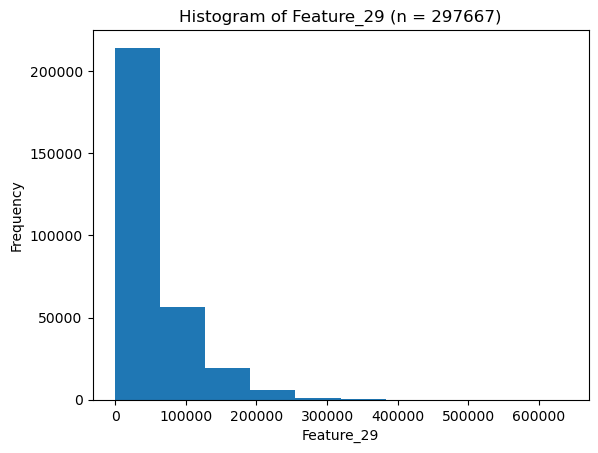

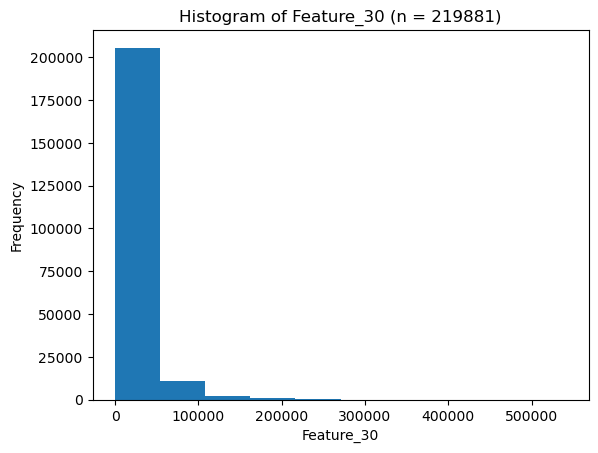

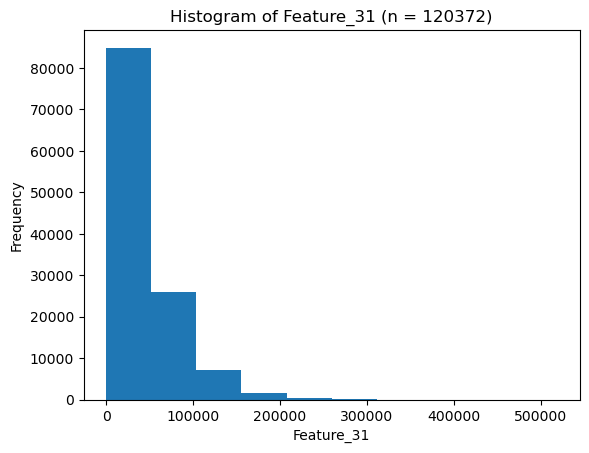

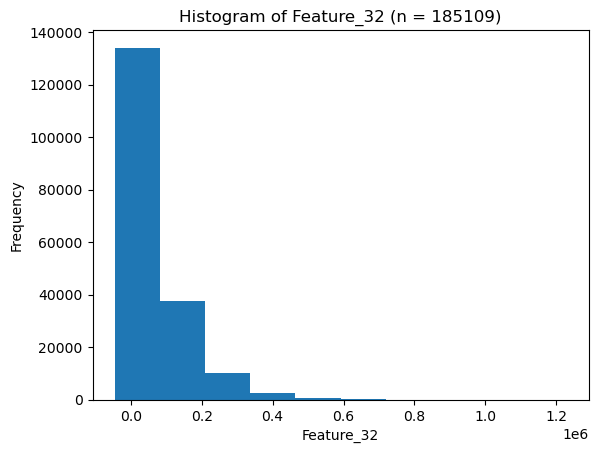

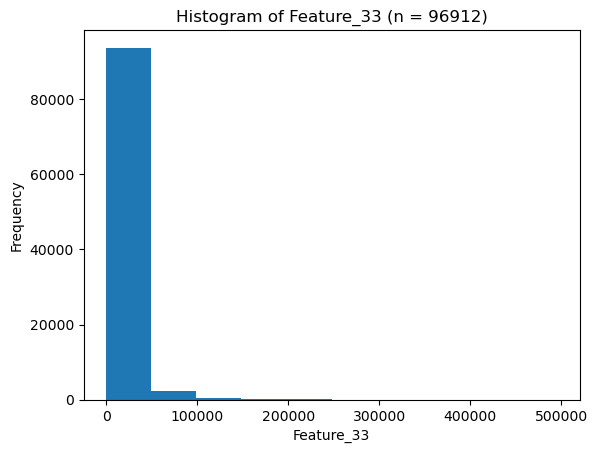

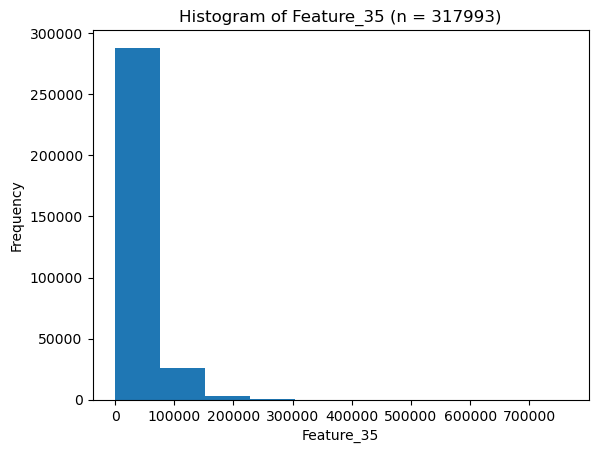

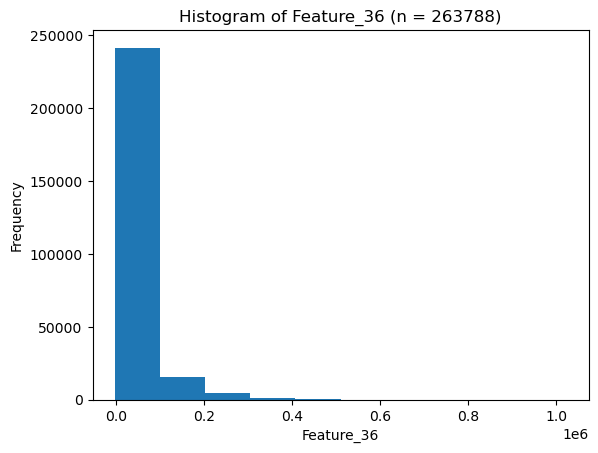

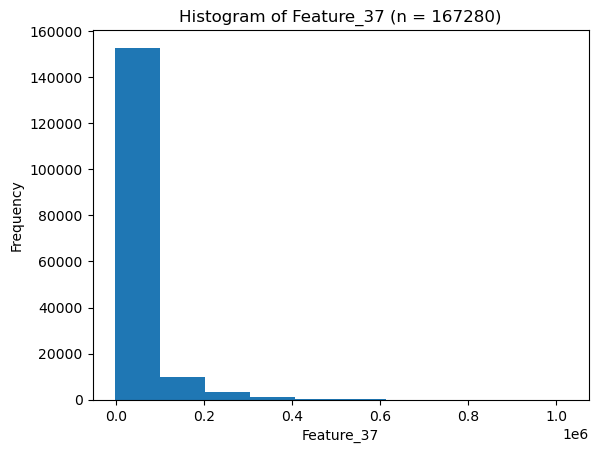

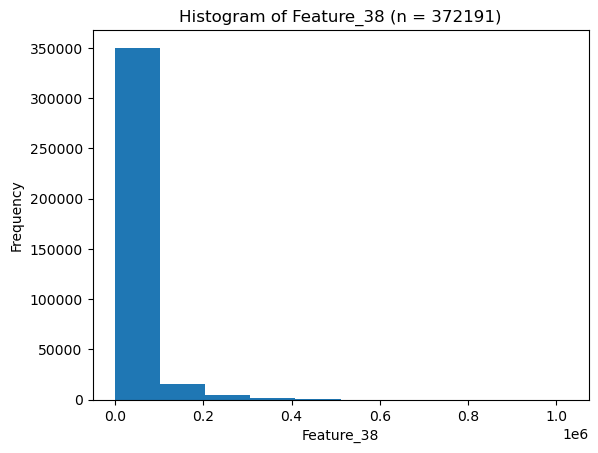

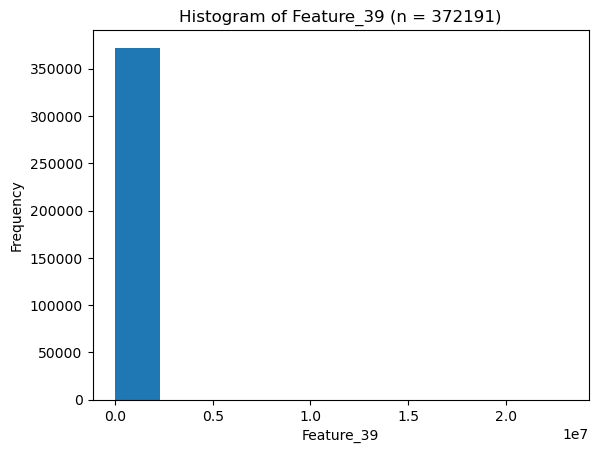

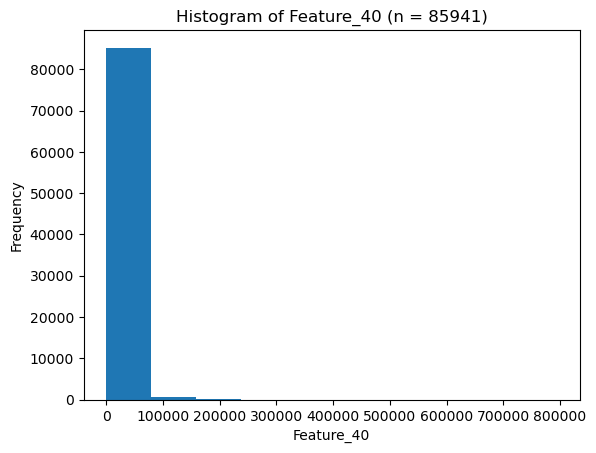

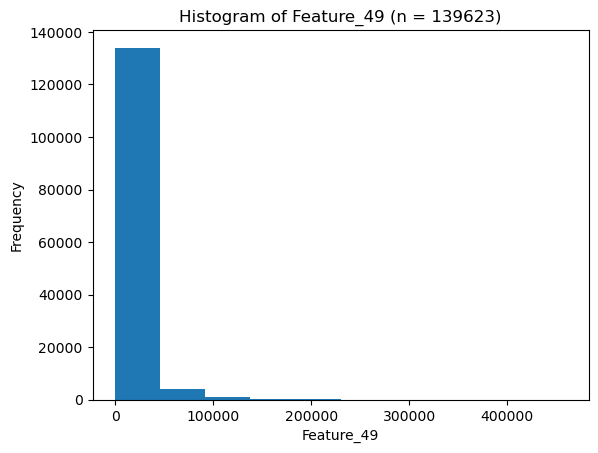

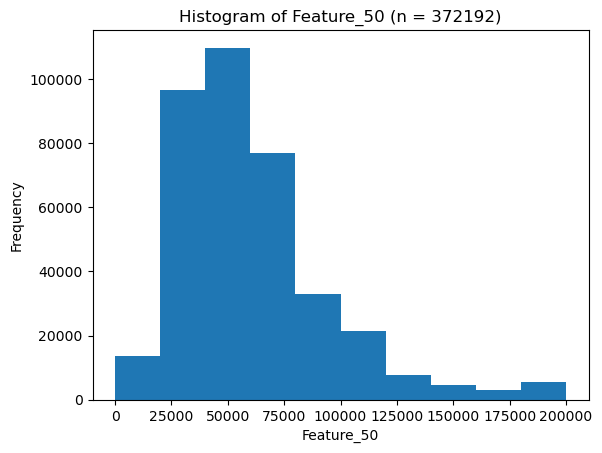

In [19]:
numerical_columns = df_dropped.select_dtypes('number')
numerical_columns.columns

for i in numerical_columns.columns:
    plt.hist(numerical_columns[i])
    plt.title(f'Histogram of {i} (n = {sum(numerical_columns[i].notna())})')
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.show()

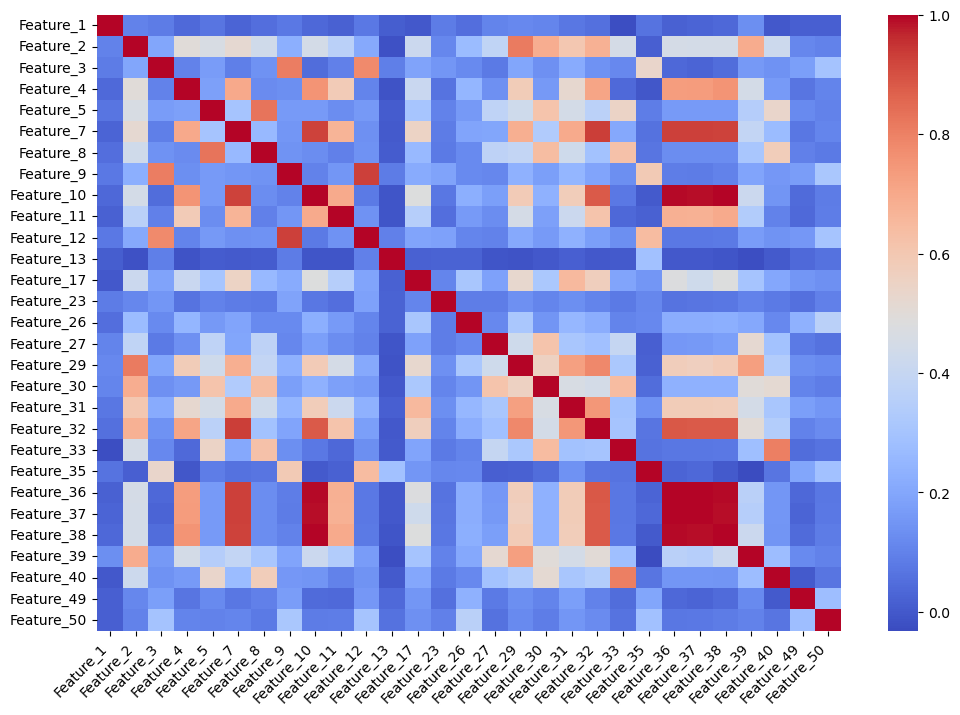

In [20]:
numerical_corr = numerical_columns.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(numerical_corr, annot=False, fmt=".2f", cmap='coolwarm',
            xticklabels=numerical_corr.columns, yticklabels=numerical_corr.columns)

# Adjust the layout
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()

# Show the plot
plt.show()

In [21]:
cat_high_corr = ((numerical_corr > 0.99).sum() > 1)[((numerical_corr > 0.99).sum() > 1) == True]
print("Columns with high correlation with each other: " + str(list(cat_high_corr.index)))

Columns with high correlation with each other: ['Feature_10', 'Feature_36', 'Feature_37', 'Feature_38']


In [22]:
numerical_columns_dropped = numerical_columns.drop(columns = cat_high_corr.index[1:],axis = 1)

### Final check on the dropped columns

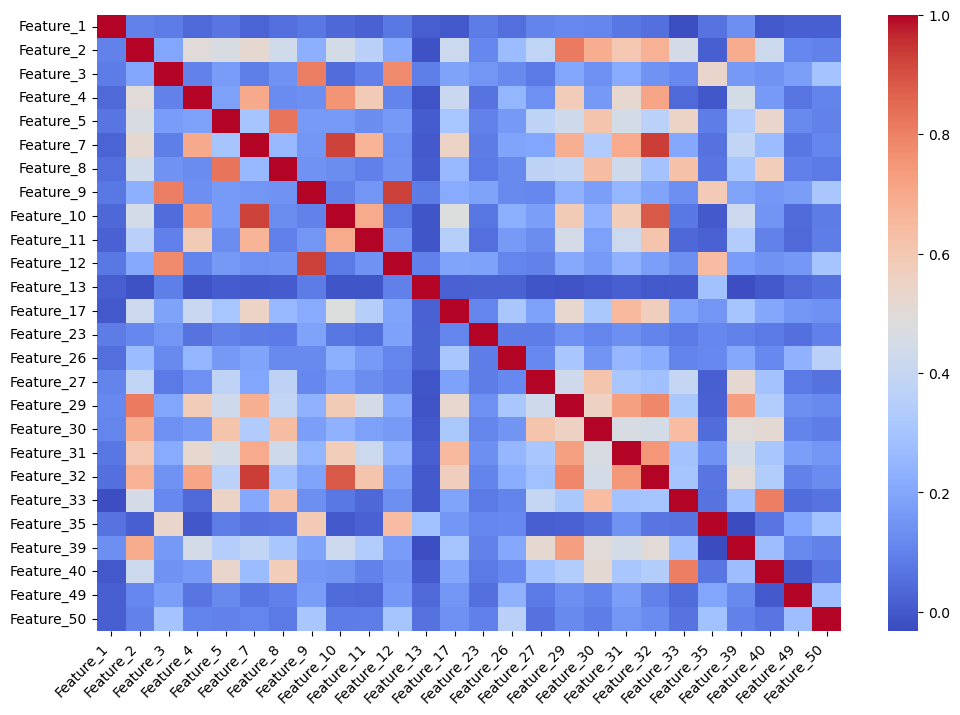

In [24]:
numerical_corr_dropped = numerical_columns_dropped.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(numerical_corr_dropped, annot=False, fmt=".2f", cmap='coolwarm',
            xticklabels=numerical_corr_dropped.columns, yticklabels=numerical_corr_dropped.columns)

# Adjust the layout
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()

# Show the plot
plt.show()

In [25]:
categorical_columns = df_dropped.select_dtypes(include = ['object','bool'])

for i in categorical_columns.columns:
    print(categorical_columns[i].value_counts())

Feature_15
a55475b1        207656
P159_130_59      62682
P12_6_178        37970
P148_110_5       15556
P109_133_183     13642
P53_45_92         7787
P52_56_90         5375
P33_29_177        5102
P21_79_33         4330
P100_96_175       4282
P128_43_169       2381
P184_3_97         1591
P187_118_47        668
P65_94_74          612
P201_79_148        591
P105_126_172       475
P216_109_183       398
P177_46_174        209
P121_6_80          204
P160_128_10        151
P48_73_87          146
P21_123_87         110
P110_120_162        47
P75_42_174          37
P137_157_60         27
P143_21_170         26
P156_122_160        23
P193_109_73         20
P156_50_173         18
P137_6_96           15
P76_145_175         12
P98_19_172          11
P49_162_170          8
P181_140_94          7
P175_82_175          6
P141_125_135         6
P3_103_80            4
P38_69_128           2
P126_161_96          2
P187_21_169          1
P93_39_173           1
P58_25_91            1
Name: count, dtype: int

In [26]:
encoder = LabelEncoder()
encoded_categorical_columns = categorical_columns.apply(lambda col: encoder.fit_transform(col))

In [27]:
chisq,pvalues = chi2(encoded_categorical_columns,df['target'])
pvalues_df = pd.DataFrame(pvalues)
pvalues_df['Feature'] = encoded_categorical_columns.columns

chi2_features = SelectKBest(chi2, k = 10) # Adjust k as needed
X_kbest = chi2_features.fit_transform(encoded_categorical_columns, df['target'])

selected_features = encoded_categorical_columns.columns[chi2_features.get_support()]
print(selected_features)

Index(['Feature_15', 'Feature_18', 'Feature_21', 'Feature_22', 'Feature_24',
       'Feature_25', 'Feature_34', 'Feature_42', 'Feature_44', 'Feature_45'],
      dtype='object')


In [28]:
categorical_columns_dropped = categorical_columns[selected_features]

In [29]:
df_selected_columns = pd.concat([numerical_columns_dropped, categorical_columns_dropped], axis = 1)
print(df_selected_columns.columns)

Index(['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11',
       'Feature_12', 'Feature_13', 'Feature_17', 'Feature_23', 'Feature_26',
       'Feature_27', 'Feature_29', 'Feature_30', 'Feature_31', 'Feature_32',
       'Feature_33', 'Feature_35', 'Feature_39', 'Feature_40', 'Feature_49',
       'Feature_50', 'Feature_15', 'Feature_18', 'Feature_21', 'Feature_22',
       'Feature_24', 'Feature_25', 'Feature_34', 'Feature_42', 'Feature_44',
       'Feature_45'],
      dtype='object')


# Pre-processing of selected columns for models to run

## Dealing with missing values

In [32]:
numerical_columns_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372192 entries, 0 to 372191
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Feature_1   372192 non-null  int64  
 1   Feature_2   235204 non-null  float64
 2   Feature_3   372192 non-null  int64  
 3   Feature_4   372191 non-null  float64
 4   Feature_5   219881 non-null  float64
 5   Feature_7   167106 non-null  float64
 6   Feature_8   121838 non-null  float64
 7   Feature_9   372192 non-null  float64
 8   Feature_10  372191 non-null  float64
 9   Feature_11  372191 non-null  float64
 10  Feature_12  372192 non-null  float64
 11  Feature_13  372192 non-null  float64
 12  Feature_17  264581 non-null  float64
 13  Feature_23  184670 non-null  float64
 14  Feature_26  247859 non-null  float64
 15  Feature_27  297667 non-null  float64
 16  Feature_29  297667 non-null  float64
 17  Feature_30  219881 non-null  float64
 18  Feature_31  120372 non-null  float64
 19  Fe

Imputing the numerical columns with the mean and the categorical columns with the mode.

In [34]:
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

numerical_columns_dropped_filled = numerical_imputer.fit_transform(numerical_columns_dropped)
numerical_columns_dropped_filled_df = pd.DataFrame(numerical_columns_dropped_filled, columns = numerical_columns_dropped.columns)

categorical_columns_dropped_filled = categorical_imputer.fit_transform(categorical_columns_dropped)
categorical_columns_dropped_filled_df = pd.DataFrame(categorical_columns_dropped_filled, columns = categorical_columns_dropped.columns)

In [35]:
df_selected_columns_filled = pd.concat([numerical_columns_dropped_filled_df, categorical_columns_dropped_filled_df], axis = 1)
df_selected_columns_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372192 entries, 0 to 372191
Data columns (total 36 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Feature_1   372192 non-null  float64
 1   Feature_2   372192 non-null  float64
 2   Feature_3   372192 non-null  float64
 3   Feature_4   372192 non-null  float64
 4   Feature_5   372192 non-null  float64
 5   Feature_7   372192 non-null  float64
 6   Feature_8   372192 non-null  float64
 7   Feature_9   372192 non-null  float64
 8   Feature_10  372192 non-null  float64
 9   Feature_11  372192 non-null  float64
 10  Feature_12  372192 non-null  float64
 11  Feature_13  372192 non-null  float64
 12  Feature_17  372192 non-null  float64
 13  Feature_23  372192 non-null  float64
 14  Feature_26  372192 non-null  float64
 15  Feature_27  372192 non-null  float64
 16  Feature_29  372192 non-null  float64
 17  Feature_30  372192 non-null  float64
 18  Feature_31  372192 non-null  float64
 19  Fe

## Dealing with categorical columns

In [37]:
categorical_columns_dropped_filled_df.nunique()

Feature_15     42
Feature_18     64
Feature_21     41
Feature_22    127
Feature_24     17
Feature_25     13
Feature_34    223
Feature_42      5
Feature_44      6
Feature_45      6
dtype: int64

In [38]:
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False,drop='first')
categorical_columns_encoded = encoder.fit_transform(categorical_columns_dropped_filled_df)
categorical_columns_encoded_df = pd.DataFrame(categorical_columns_encoded, columns = encoder.get_feature_names_out())

In [39]:
df_processed= pd.concat([numerical_columns_dropped_filled_df, categorical_columns_encoded_df], axis = 1)

## Train Test Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_processed, y, test_size = 0.3, random_state=42, stratify=y)

In [42]:
print(sum(y_train == 1))
print(sum(y_train == 0))

8918
251616


In [43]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [44]:
print(sum(y_res == 1))
print(sum(y_res == 0))

251616
251616


# Model Building

Logistic Regression,
KNNClassifier,
SVM,
DecisionTree,
Forest,
Neural Network,
Adaboost,
XGBoost

In [ ]:
from sklearn.metrics import classification_report,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# def train_eval_model(model, X_train, X_test, y_train, y_test):
#     model_name = model.__class__.__name__
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(f"Classification Report for {model_name}:")
#     print(classification_report(y_test, y_pred))

# # Models to evaluate
# models = [
#     LogisticRegression(max_iter=1000),  # Increased max_iter for convergence
#     KNeighborsClassifier(),
#     SVC(),
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     AdaBoostClassifier(),
#     MLPClassifier(max_iter=1000),  # Increased max_iter for convergence
#     XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# ]

# # Train and evaluate each model
# for model in models:
#     train_eval_model(model, X_res, X_test, y_res, y_test)


In [49]:
reg = LogisticRegression(max_iter = 1000)
reg.fit(X_res, y_res)
y_pred_reg = reg.predict(X_test)
print(f"Classification Report for {reg.__class__.__name__}:")
print(classification_report(y_test, y_pred_reg))
f1_score_reg = f1_score(y_test, y_pred_reg)
print(f1_score_reg)

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.98      0.61      0.75    107836
           1       0.05      0.58      0.09      3822

    accuracy                           0.61    111658
   macro avg       0.51      0.60      0.42    111658
weighted avg       0.94      0.61      0.73    111658

0.09252001334222815


In [61]:
X_res_contiguous = np.ascontiguousarray(X_res)
y_res_contiguous = np.ascontiguousarray(y_res)
X_test_contiguous = np.ascontiguousarray(X_test)

knn = KNeighborsClassifier()
knn.fit(X_res_contiguous, y_res_contiguous)
y_pred_knn = knn.predict(X_test_contiguous)
print(f"Classification Report for {knn.__class__.__name__}:")
print(classification_report(y_test, y_pred_knn))
f1_score_knn = f1_score(y_test, y_pred_knn)
print(f1_score_knn)

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88    107836
           1       0.05      0.28      0.08      3822

    accuracy                           0.78    111658
   macro avg       0.51      0.54      0.48    111658
weighted avg       0.94      0.78      0.85    111658

0.07977877111902416


In [62]:
# svm = SVC()
# svm.fit(X_res, y_res)
# y_pred_svm = svm.predict(X_test)
# print(f"Classification Report for {svm.__class__.__name__}:")
# print(classification_report(y_test, y_pred_svm))
# f1_score_svm = f1_score(y_test, y_pred_svm)
# print(f1_score_svm) 

In [63]:
tree = DecisionTreeClassifier()
tree.fit(X_res, y_res)
y_pred_tree = tree.predict(X_test)
print(f"Classification Report for {tree.__class__.__name__}:")
print(classification_report(y_test, y_pred_tree))
f1_score_tree = f1_score(y_test, y_pred_tree)
print(f1_score_tree)

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97    107836
           1       0.13      0.17      0.15      3822

    accuracy                           0.93    111658
   macro avg       0.55      0.57      0.56    111658
weighted avg       0.94      0.93      0.94    111658

0.14983937586048646


In [64]:
forest = RandomForestClassifier()
forest.fit(X_res, y_res)
y_pred_forest = forest.predict(X_test)
print(f"Classification Report for {forest.__class__.__name__}:")
print(classification_report(y_test, y_pred_forest))
f1_score_forest = f1_score(y_test, y_pred_forest)
print(f1_score_forest)

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    107836
           1       0.31      0.05      0.09      3822

    accuracy                           0.96    111658
   macro avg       0.64      0.52      0.53    111658
weighted avg       0.94      0.96      0.95    111658

0.08787267428827618


In [ ]:
ada = AdaBoostClassifier()
ada.fit(X_res, y_res)
y_pred_ada = ada.predict(X_test)
print(f"Classification Report for {ada.__class__.__name__}:")
print(classification_report(y_test, y_pred_ada))
f1_score_ada = f1_score(y_test, y_pred_ada)
print(f1_score_ada)

In [ ]:
mlp = MLPClassifier()
mlp.fit(X_res, y_res)
y_pred_mlp = mlp.predict(X_test)
print(f"Classification Report for {mlp.__class__.__name__}:")
print(classification_report(y_test, y_pred_mlp))
f1_score_mlp = f1_score(y_test, y_pred_mlp)
print(f1_score_mlp)

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_res, y_res)
y_pred_xgb = xgb.predict(X_test)
print(f"Classification Report for {xgb.__class__.__name__}:")
print(classification_report(y_test, y_pred_xgb))
f1_score_xgb = f1_score(y_test, y_pred_xgb)
print(f1_score_xgb)

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
hist = HistGradientBoostingClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
hist.fit(X_res, y_res)
y_pred_hist = hist.predict(X_test)
print(f"Classification Report for {hist.__class__.__name__}:")
print(classification_report(y_test, y_pred_hist))
f1_score_hist = f1_score(y_test, y_pred_hist)
print(f1_score_hist)


## optimize hyperparameters 

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
# Setup GridSearchCV
grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, scoring='f1', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_res, y_res)

# Get the best estimator
best_ada = grid_search.best_estimator_

# Predict using the best estimator
y_pred_ada = best_ada.predict(X_test)

# Evaluation
print(f"Classification Report for {best_ada.__class__.__name__}:")
print(classification_report(y_test, y_pred_ada))
f1_score_ada = f1_score(y_test, y_pred_ada)
print(f1_score_ada)


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score: {:.2f}".format(grid_search.best_score_))

# Optionally, evaluate it on the test set
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

from sklearn.metrics import f1_score
print("Test set F1 score: {:.2f}".format(f1_score(y_test, y_pred_xgb)))